## Disaggregated forecast models for anomaly detection applied to business outcomes
Final Paper submitted to the Center for Mathematical Sciences Applied to Industry of the Institute of Mathematics and Computer Sciences – USP, in partial fulfillment of the requirements for the MBA in Data Science

Forecasting is a critical capability that enables organizations to allocate resources effectively, establish targets, and identify any discrepancies in business performance, by providing organizations with insights, forecasting allows them to adapt their strategies and make changes such as hiring additional staff or increasing production, in order to improve their chances of success. This monograph focuses on determining when forecasted sales diverge significantly from actual sales, in order to identify anomalies in business performance. The proposed research will forecast short periods of less than a year, to identify deviations from expected outcomes across various segments of an organization. The specific objectives of this research are to develop a systematic method for forecasting different segments, determine the most suitable forecasting methodology, evaluate various model parameters and hyper-parameters, and implement a notification system to alert decision-makers of significant deviations in the expected forecast. The outcomes of this research will be beneficial for organizations in identifying potential issues and taking timely action to address them, thereby enhancing their chances of success in achieving business their objectives.

#### Data Source: Time Series Kaggle Ecuador
Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. A. Data Access and Use. You may access and use the Competition Data for non-commercial purposes only, including for participating in the Competition and on Kaggle.com forums, and for academic research and education.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [26]:
#Import Libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import make_moons, make_blobs, make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
np.set_printoptions(suppress=True)

train_source = pd.read_csv('/Users/kalluf/Desktop/USP/MBA/TCC/kaggle/store-sales-time-series-forecasting/train.csv', index_col=0, parse_dates=True)


### Data Processing
A subset of the original train data set was created. The training period was defined from 2016-01-01 to 2017-01-31 and the test was from 2017-02-01 to 2017-02-28. In this case, we are simulating that the managers are interested in monitoring the sales activity of all 54 stores in the month of February 2017.

In [27]:
#Define a stable period of time Jan 2016 to Jan 2017 for training and for test Feb 2017, likely to predict only 

#Split into Train and Test
train = train_source[(train_source['date'] > '2015-12-31')]
train = train[(train['date'] < '2017-02-01')]

test  = train_source[(train_source['date'] > '2017-01-31')]
test  = test[(test['date'] < '2017-03-01')]

print('Train From:',min(train['date']),'To:',max(train['date']))
print('Test  From:',min(test['date']),'To:', max(test['date']))


Train From: 2016-01-01 To: 2017-01-31
Test  From: 2017-02-01 To: 2017-02-28


In [28]:
# Verify train df and fill missing values using 'ffill' (forward fill)
print(train.isna().sum())
train.fillna(method='ffill', inplace=True)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [29]:
# Verify test df and fill missing values using 'ffill' (forward fill)
print(test.isna().sum())
test.fillna(method='ffill', inplace=True)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [30]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train.set_index('date',inplace = True)
test.set_index('date',inplace = True)

In [31]:
test.index

DatetimeIndex(['2017-02-01', '2017-02-01', '2017-02-01', '2017-02-01',
               '2017-02-01', '2017-02-01', '2017-02-01', '2017-02-01',
               '2017-02-01', '2017-02-01',
               ...
               '2017-02-28', '2017-02-28', '2017-02-28', '2017-02-28',
               '2017-02-28', '2017-02-28', '2017-02-28', '2017-02-28',
               '2017-02-28', '2017-02-28'],
              dtype='datetime64[ns]', name='date', length=49896, freq=None)

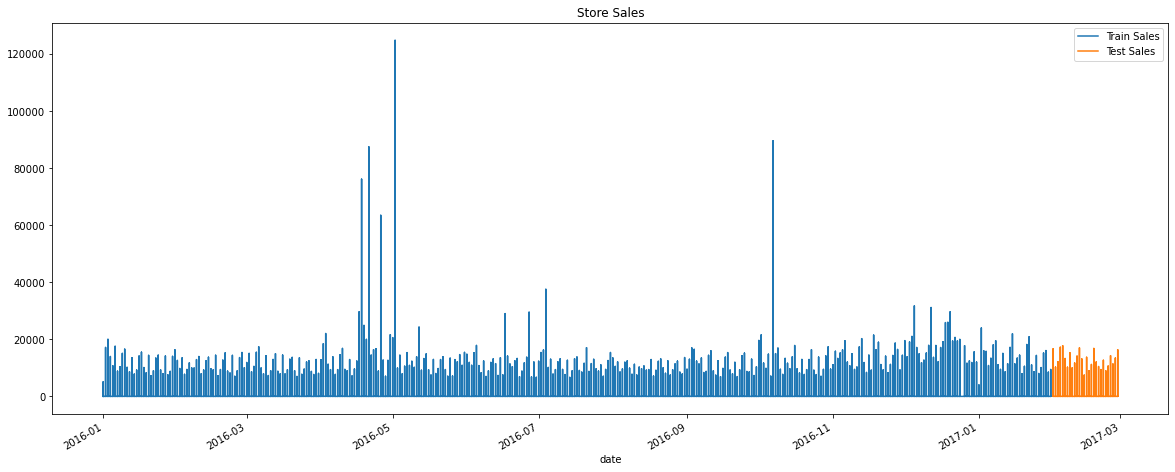

In [32]:
#Plot Train and Test Periods

train.sales.plot(title = 'Store Sales',figsize=(20,8))
test.sales.plot(title = 'Store Sales',figsize=(20,8))
plt.legend(labels=['Train Sales', 'Test Sales'], loc='upper right')
plt.show()

In [33]:
#Pivot Sales, one store per column
sales = pd.pivot_table(train, values = 'sales', index=['date'], columns = 'store_nbr').reset_index()

In [34]:
sales.tail(2)

store_nbr,date,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
394,2017-01-30,330.026545,393.375333,939.543879,402.761818,285.561242,452.939454,651.810879,532.270030,457.072364,...,971.901577,659.040000,947.447848,589.506821,913.215910,522.106242,700.892030,0.0,283.037000,235.285788
395,2017-01-31,306.819576,477.898910,999.035152,341.904939,284.734364,474.716182,601.613152,573.081121,656.191485,...,1009.506788,735.805576,950.959758,636.833242,865.478395,504.318879,622.304212,0.0,316.430394,256.971545


----------
### In order to evaluate model feasibility one individual store was used (store 12), but the same approach will be used to predict sales for all 54 stores.

In [35]:
#
store = [12] 
    
# selecting rows based on condition 
train_store = train[train['store_nbr'].isin(store)] 
test_store = test[test['store_nbr'].isin(store)]    

Text(0.5, 1.0, 'Sales per month by store_nbr')

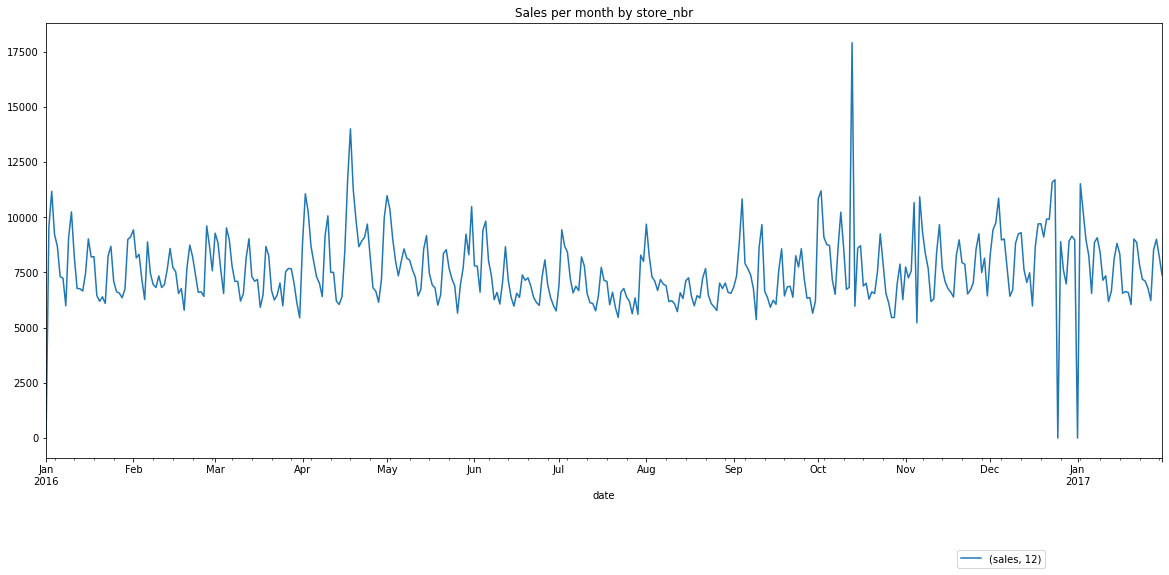

In [36]:
store_nbr_sales_train_day = train_store.groupby(['date', 'store_nbr']).aggregate({'sales': 'sum'}).unstack().resample('D').sum()
store_nbr_sales_train_day.plot(figsize=(20,8))
plt.legend(bbox_to_anchor=(0.9,-.2), ncol=9)
plt.title("Sales per month by store_nbr")


Text(0.5, 1.0, 'Sales per month by store_nbr')

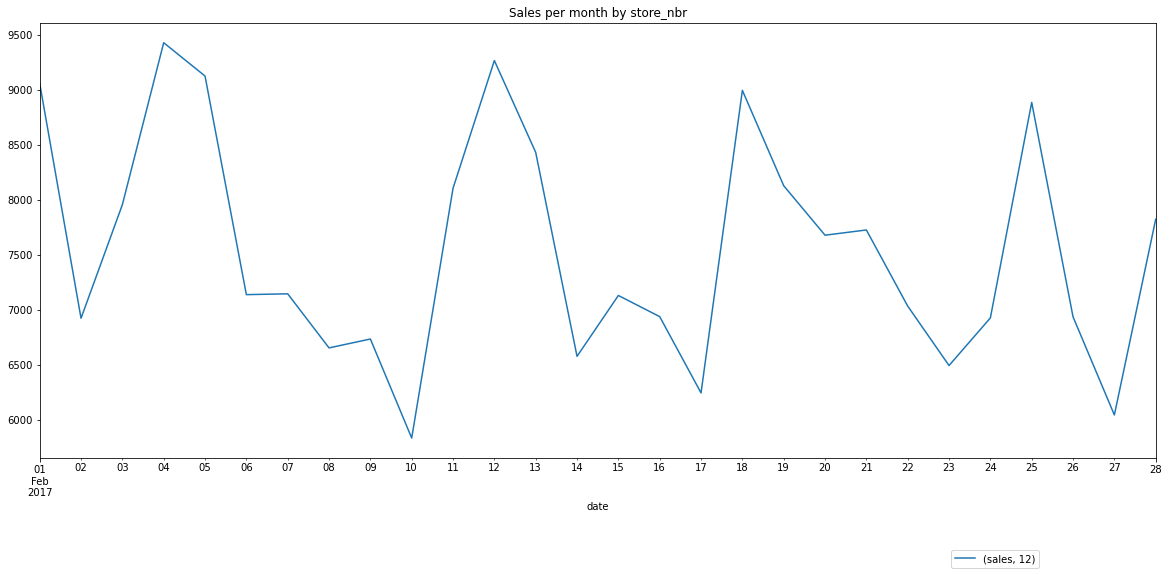

In [37]:
store_nbr_sales_test_day = test_store.groupby(['date', 'store_nbr']).aggregate({'sales': 'sum'}).unstack().resample('D').sum()
store_nbr_sales_test_day.plot(figsize=(20,8))
plt.legend(bbox_to_anchor=(0.9,-.2), ncol=9)
plt.title("Sales per month by store_nbr")


<AxesSubplot:title={'center':'Store Sales'}, xlabel='date'>

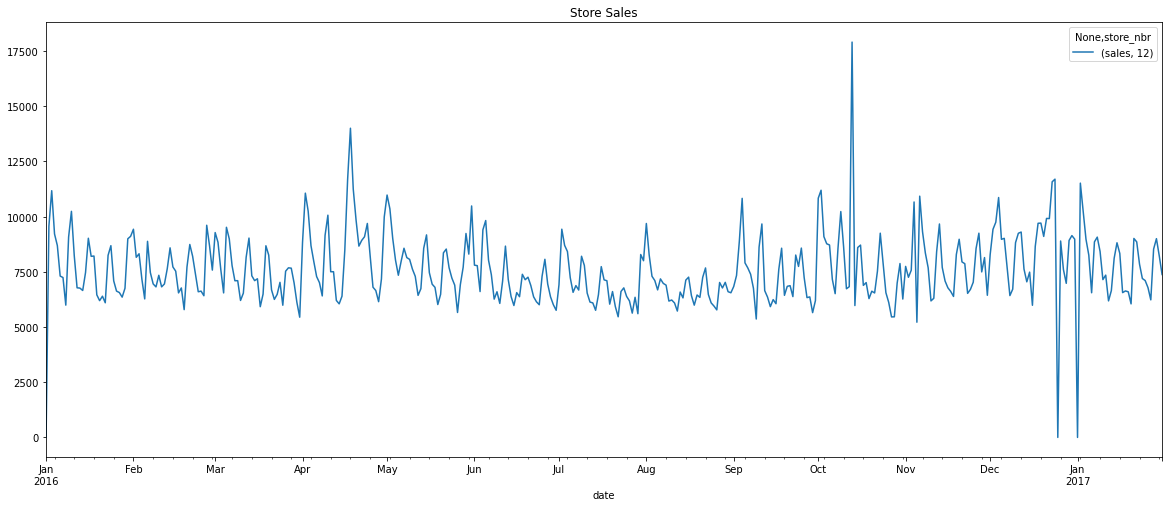

In [38]:
store_nbr_sales_train_day.plot(title = 'Store Sales',figsize=(20,8))

In [39]:
store_nbr_sales_train_day.head()

,sales
store_nbr,12
date,
2016-01-01,0.000000
2016-01-02,9566.088000
2016-01-03,11174.043000
2016-01-04,9214.915986
2016-01-05,8689.454000


In [40]:
#Backword fill used to enable decomposition as model='addtitive'
backward_Fill = store_nbr_sales_train_day[store_nbr_sales_train_day['sales']>1]['sales'].bfill()
backward_Fill.head(5)

store_nbr,12
date,
2016-01-01,9566.088000
2016-01-02,9566.088000
2016-01-03,11174.043000
2016-01-04,9214.915986
2016-01-05,8689.454000


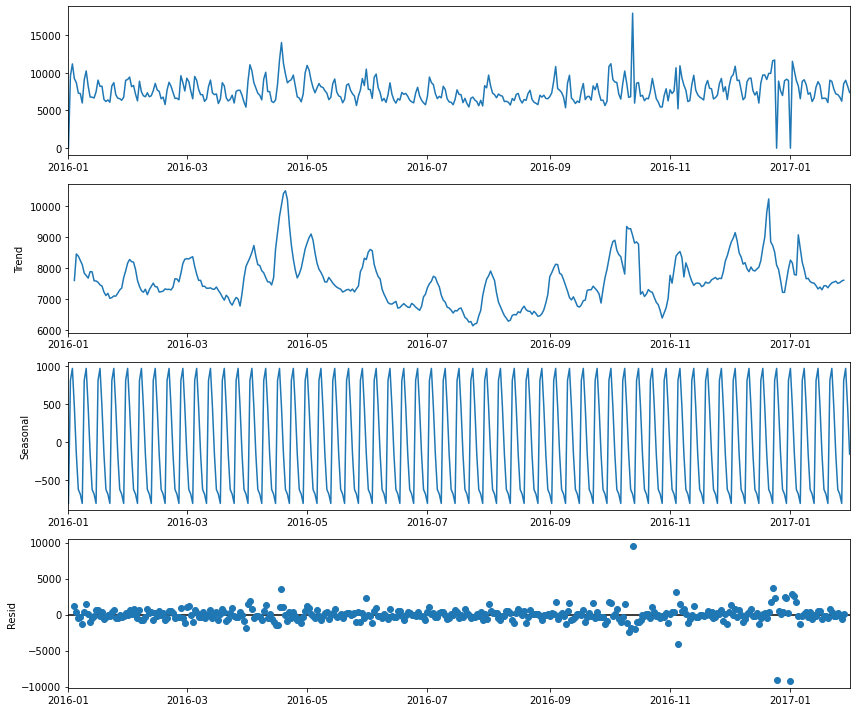

In [41]:
#Decompose a time series into its components: trend, seasonality, and residuals.
#Assuming an additive model, which means that the time series is modeled as the sum of its components and
#the sesonality is weekly

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

store_nbr_sales_train_day.fillna(method='ffill', inplace=True)
#additive
result = seasonal_decompose(store_nbr_sales_train_day['sales'], model='additive', period=7)
rcParams['figure.figsize'] = 12, 10
fig = result.plot()

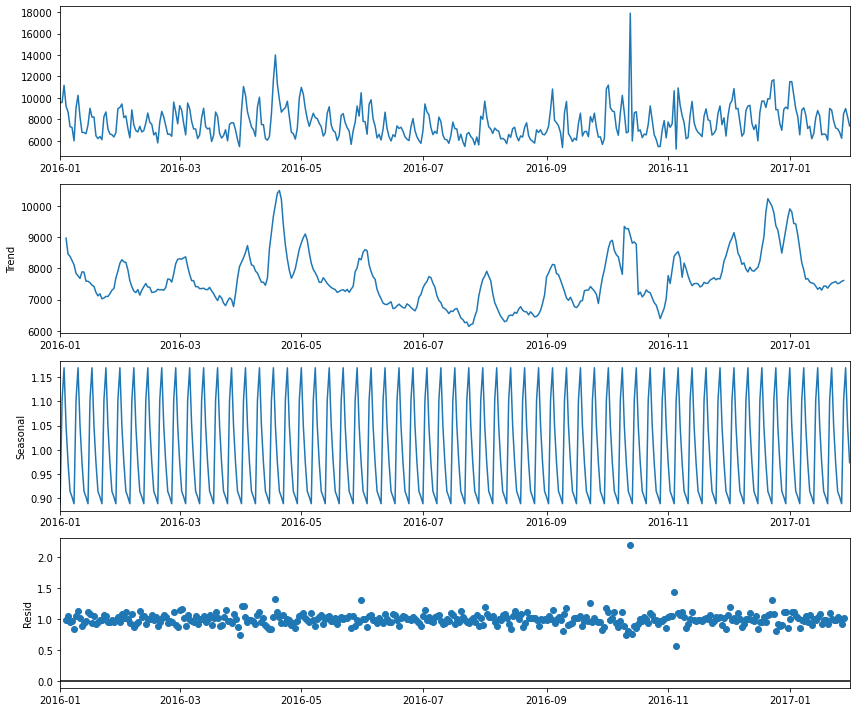

In [42]:
#Decompose a time series into its components: trend, seasonality, and residuals.
#Assuming multiplicative model, where the time series is modeled as the product of its components and
#the sesonality is weekly


from statsmodels.tsa.seasonal import seasonal_decompose
result_m = seasonal_decompose(backward_Fill, model='multiplicative', period=7)
rcParams['figure.figsize'] = 12, 10
fig =result_m.plot()

# Multiplicative model can not handle zeros, missing data, thereore the additive model is more flexible for this
# type of application that aims to have limited inputs from users...

In [43]:
#Correlation and Partialcorrelation
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

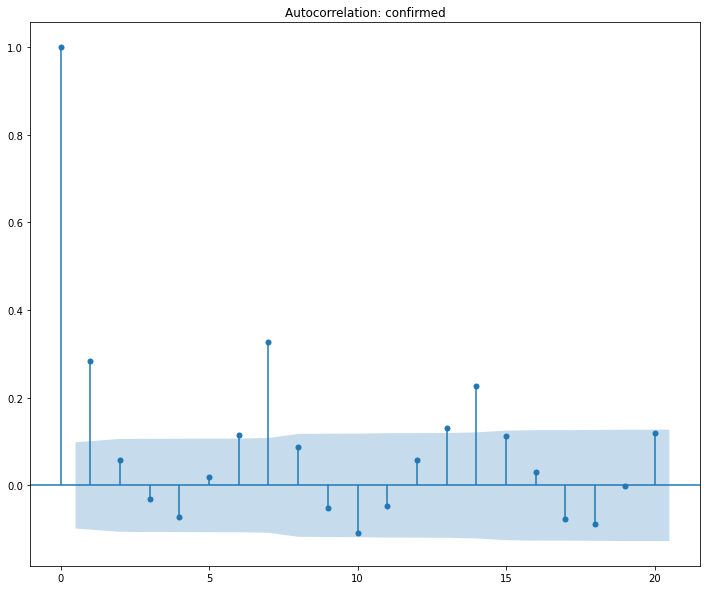

In [48]:
#Autocorrelation
#whether there is any significant correlation between the sales data and its lagged values and determine
#if there is any seasonality or dependence in the sales data.
title='Autocorrelation: confirmed'
lags=20
plot_acf(store_nbr_sales_train_day['sales'],title=title,lags=lags);

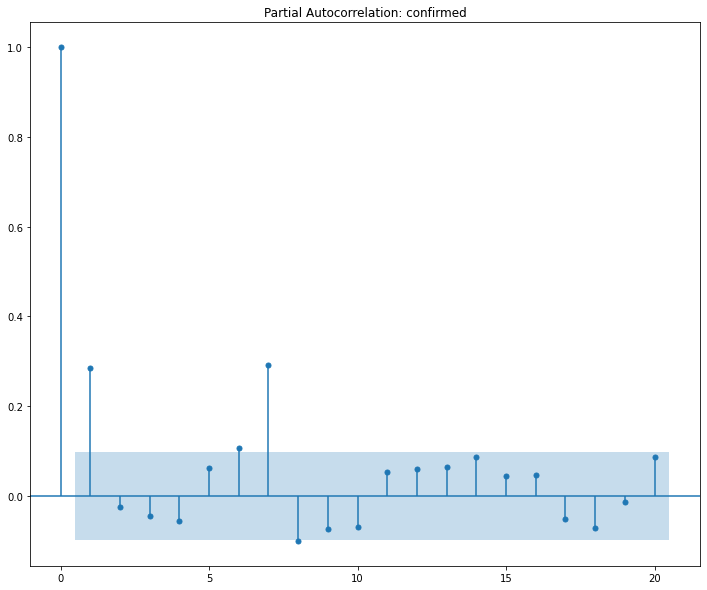

In [50]:
#Partial Autocorrelation 
title='Partial Autocorrelation: confirmed'
lags=20
plot_pacf(store_nbr_sales_train_day['sales'],title=title,lags=lags);

# Model Selection
Three approaches were tested: Holt-Winters, Theta model, and Long short-term memory (LSTM). These models were evaluated on their execution time and MAPE scores. How long an individual model takes to be completed is critical for the viability of the proposed approach, in this study there are 54 individual models but the suggested application of this method is aimed at business questions involving thousands of individual models. For example, if each of the 54 stores had 20 products, it would require 54x20 individual models or 1,080 models to predict product sales by store.


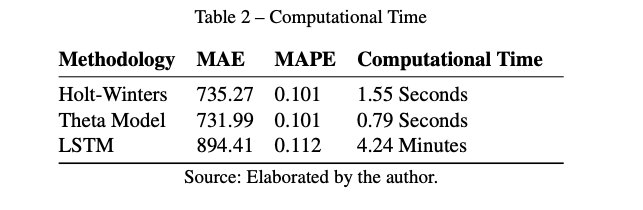

## Holt-Winters

In [22]:
import time

# get the start time
st = time.time()
# --------------------------------------------------------------------------------------------------- #

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import ExponentialSmoothing
ajustado_HW = ExponentialSmoothing(store_nbr_sales_train_day['sales'],trend='add',seasonal='add',seasonal_periods=7).fit()
predito_HW = ajustado_HW.forecast(28).rename('Previsão Holt-Winters')


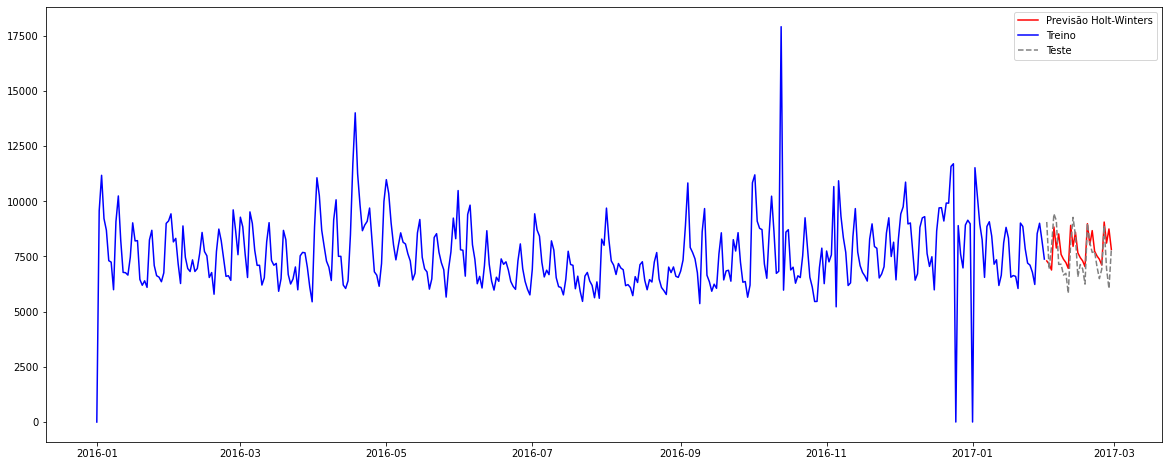

In [23]:
plt.figure(figsize = (20,8))
plt.plot(predito_HW,  color = 'red', label='Previsão Holt-Winters')
plt.plot(store_nbr_sales_train_day['sales'],color = 'blue', label = 'Treino')
plt.plot(store_nbr_sales_test_day['sales'], label='Teste',ls='--',c='grey')
#plt.title('Sales_Store_1')
plt.legend()
plt.show()

In [24]:
#HOLT-WINTERS
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
print('HW_MAE',mean_absolute_error(store_nbr_sales_test_day['sales'],predito_HW))
print('HW_MAPE:',round(mean_absolute_percentage_error(store_nbr_sales_test_day['sales'],predito_HW),4))


HW_MAE 735.2722397673178
HW_MAPE: 0.1017


In [25]:
#HOLT-WINTERS Execution Time
et = time.time()
el = et-st

print('Holt-Winters execution time',el)

Holt-Winters execution time 2.408433198928833


## Theta Model

In [128]:
import time

# get the start time
st = time.time()


from statsmodels.tsa.forecasting.theta import ThetaModel
#tm = ThetaModel(store_nbr_sales_train_day['sales'],method="multiplicative",deseasonalize=True,period=7)
tm = ThetaModel(store_nbr_sales_train_day['sales'],method="additive",deseasonalize=True,period=7)

res = tm.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                     12   No. Observations:                  397
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sun, 29 Jan 2023   Deseas. Method:               Additive
Time:                        11:36:26   Period:                              7
Sample:                    01-01-2016                                         
                         - 01-31-2017                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0    0.47147885294450664
alpha  0.3309687251476959
-------------------------


In [129]:
predito_theta = res.forecast(28)

In [132]:
predito_theta

2017-02-01    6960.877025
2017-02-02    6838.986492
2017-02-03    8458.635242
2017-02-04    8616.790096
2017-02-05    8107.125143
2017-02-06    7489.116261
2017-02-07    7024.218397
2017-02-08    6962.527201
2017-02-09    6840.636668
2017-02-10    8460.285418
2017-02-11    8618.440272
2017-02-12    8108.775319
2017-02-13    7490.766437
2017-02-14    7025.868573
2017-02-15    6964.177377
2017-02-16    6842.286844
2017-02-17    8461.935594
2017-02-18    8620.090448
2017-02-19    8110.425495
2017-02-20    7492.416613
2017-02-21    7027.518749
2017-02-22    6965.827553
2017-02-23    6843.937020
2017-02-24    8463.585770
2017-02-25    8621.740624
2017-02-26    8112.075671
2017-02-27    7494.066789
2017-02-28    7029.168925
Freq: D, Name: forecast, dtype: float64

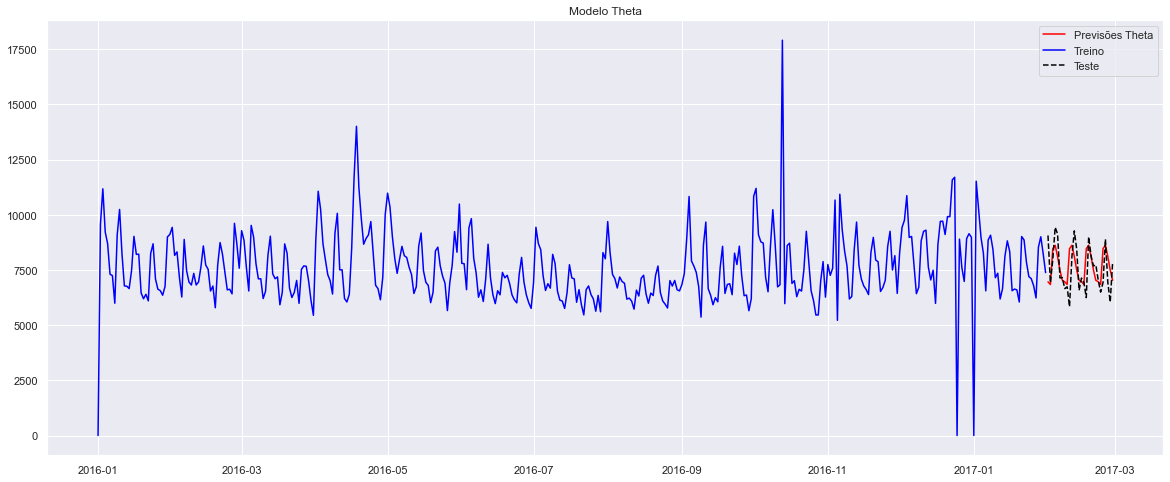

In [130]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize = (20,8))

plt.plot(predito_theta,  color = 'red', label = 'Previsões Theta')
plt.plot(store_nbr_sales_train_day['sales'],color = 'blue', label = 'Treino')
plt.plot(store_nbr_sales_test_day['sales'], label='Teste',ls='--',c='black')
plt.title('Modelo Theta')
plt.legend()
plt.show()

In [131]:
print('Theta_MAE:',round(mean_absolute_error(store_nbr_sales_test_day['sales'],predito_theta),2))
print('Theta_MAPE:',round(mean_absolute_percentage_error(store_nbr_sales_test_day['sales'],predito_theta),4))

et = time.time()
el = et-st
print('Theta Model',el)

Theta_MAE: 731.99
Theta_MAPE: 0.101
Theta Model 3.1614086627960205


## LSTM

In [231]:
import time

# get the start time
st = time.time()
#############################################

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#Standardize the data for modeling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [232]:
scaler.fit(store_nbr_sales_train_day)

MinMaxScaler()

In [233]:
scaled_train = scaler.transform(store_nbr_sales_train_day)
scaled_test = scaler.transform(store_nbr_sales_test_day)

In [234]:
print(scaled_train.min(),scaled_train.max())
print(scaled_test.min(),scaled_test.max())

0.0 1.0
0.32591206934848593 0.526705865932568


In [235]:
# Verify the first batch
X,y = generator[0]

print(f'Dado o array: \n{X.flatten()}');
print(f'Previsão: \n {y}');

Dado o array: 
[0.         0.53428141 0.62408829 0.51466789 0.48531999 0.40812508
 0.40451422]
Previsão: 
 [[0.33463804]]


In [236]:

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


n_input = 7
n_features = 1


#Model Definition
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [237]:
model.fit_generator(generator,epochs=100)

Epoch 1/100
390/390 [==============================] - 3s 4ms/step - loss: 0.0127
Epoch 2/100
390/390 [==============================] - 2s 5ms/step - loss: 0.0077
Epoch 3/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0077
Epoch 4/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0082
Epoch 5/100
390/390 [==============================] - 2s 4ms/step - loss: 0.0076
Epoch 6/100
390/390 [==============================] - 2s 5ms/step - loss: 0.0079
Epoch 7/100
390/390 [==============================] - 2s 5ms/step - loss: 0.0075
Epoch 8/100
390/390 [==============================] - 2s 5ms/step - loss: 0.0071
Epoch 9/100
390/390 [==============================] - 3s 7ms/step - loss: 0.0076
Epoch 10/100
390/390 [==============================] - 3s 7ms/step - loss: 0.0072
Epoch 11/100
390/390 [==============================] - 3s 8ms/step - loss: 0.0072
Epoch 12/100
390/390 [==============================] - 2s 5ms/step - loss: 0.0074
Epoch 13/100


In [238]:
model.history.history.keys()

dict_keys(['loss'])

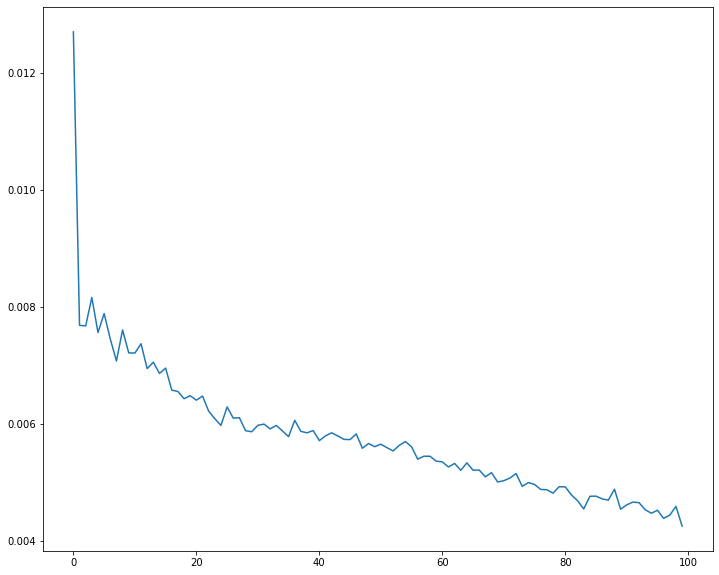

In [239]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [240]:
#Now let's consider the forecasts for the next 28 observations and compare them with the test set."

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(store_nbr_sales_test_day)):
    
   
    current_pred = model.predict(current_batch)[0]
    
    #Prediction
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [241]:
#Convert from standardized to original format
predito_LSTM = scaler.inverse_transform(test_predictions)

In [242]:
LSTM = store_nbr_sales_test_day
LSTM['Predictions'] = predito_LSTM

<AxesSubplot:xlabel='date'>

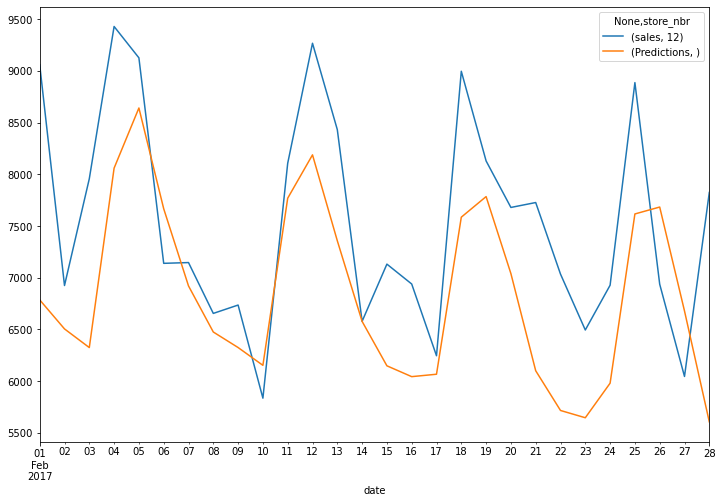

In [243]:
#Compare Test vs. Predictions
LSTM.plot(figsize=(12,8))

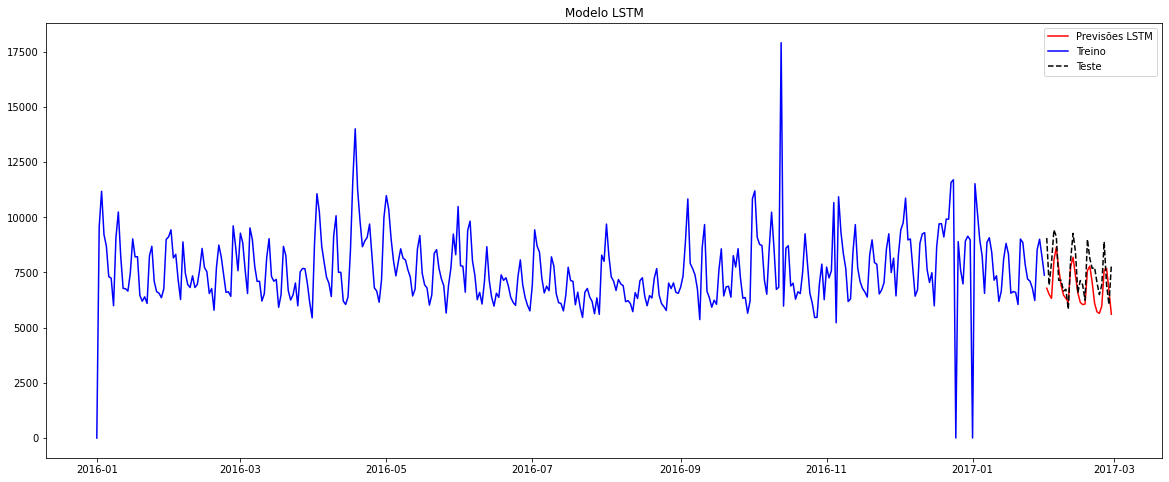

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.figure(figsize = (20,8))
mpl.style.use('default')
plt.plot(LSTM['Predictions'],  color = 'red', label = 'Previsões LSTM')
plt.plot(store_nbr_sales_train_day['sales'],color = 'blue', label = 'Treino')
plt.plot(store_nbr_sales_test_day['sales'], label='Teste',ls='--',c='black')
plt.title('Modelo LSTM')
plt.legend()
plt.show()

In [245]:
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
print('LSTM:',round(mean_absolute_error(store_nbr_sales_test_day['sales'],predito_LSTM),2))

LSTM: 871.53


In [246]:
print('LSTM:',round(mean_absolute_percentage_error(store_nbr_sales_test_day['sales'],predito_LSTM),4))


LSTM: 0.1118


In [247]:
#LSTM Execution Time
et = time.time()
el = et-st
print('LSTM',el/60,'minutos')

LSTM 3.4947518507639566 minutos


----

## LOOP THROUGH ALL STORES


### Batch Results Theta model by Store
Once the Theta model was identified as the most viable methodology within this context, the next step was to forecast the sales for all 54 stores (Figure 8), however, utilizing the same time periods for both training and test, as mentioned in Section 3.3, each model prediction is compared to the test period and a MAPE score is calculated for each store.

## Theta Model

In [30]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# get the start time
st = time.time()

In [31]:
store_nbr_sales_per_day = train.groupby(['date', 'store_nbr']).aggregate({'sales': 'sum'}).unstack().resample('D').sum()
store_nbr_sales_per_day_test = test.groupby(['date', 'store_nbr']).aggregate({'sales': 'sum'}).unstack().resample('D').sum()


In [32]:
store_nbr_sales_per_day.head(2)

sales                                                           \
store_nbr         1          2          3          4            5          6    
date                                                                            
2016-01-01     0.000      0.000      0.000      0.000      0.00000      0.000   
2016-01-02  8877.175  16625.706  47348.572  15849.819  11846.41898  22800.991   

                                                             ...            \
store_nbr          7            8            9           10  ...        45   
date                                                         ...             
2016-01-01      0.000      0.00000      0.00000     0.00000  ...      0.00   
2016-01-02  18703.899  27211.34297  26489.76997  9838.17198  ...  65194.93   

                                                                        \
store_nbr          46         47           48          49           50   
date                                                                     
2016-01-01      0.000      0.000      0.00000      0.0000      0.00000   
2016-01-02  54616.746  58537.973  48673.43798  43216.7549  32418.03904   

                                                  
store_nbr          51   52          53        54  
date                                              
2016-01-01      0.000  0.0     0.00000     0.000  
2016-01-02  20301.086  0.0  9519.19602  9028.072  

[2 rows x 54 columns]

In [33]:
store_nbr_sales_per_day_test.head(2)

sales                                                \
store_nbr             1            2          3          4          5    
date                                                                     
2017-02-01  14961.579999  18834.69700  45775.027  16086.445  12868.013   
2017-02-02  11341.542995  13777.08801  29125.074  11493.350   9682.945   

                                                                      ...  \
store_nbr            6          7            8          9         10  ...   
date                                                                  ...   
2017-02-01  21786.39900  26623.270  26997.33400  24325.153  6920.461  ...   
2017-02-02  16435.77396  20208.156  17858.35099  20164.793  6273.568  ...   

                                                                        \
store_nbr          45         46         47           48            49   
date                                                                     
2017-02-01  48659.097  31319.758  42009.791  26992.87401  44718.851000   
2017-02-02  34129.938  26812.338  33643.589  24363.99210  29676.594696   

                                                               
store_nbr          50            51   52         53        54  
date                                                           
2017-02-01  22330.175  31237.133003  0.0  18217.545  8179.633  
2017-02-02  17423.678  20155.177000  0.0  10609.524  6960.948  

[2 rows x 54 columns]

In [35]:
df_forecast = pd.DataFrame(columns=['Store','Prediction'])

#df_forecast =pd.append({'Store':store},ignore_index=True)
#df_forecast =pd.append({'Prediction':predito_theta},ignore_index=True)
#df = df.append({'Store': i}, ignore_index=True)

In [134]:
store = [] 
theta_MAE =[]
theta_MAPE =[]
theta_predictions_by_store = []
theta_predictions_by_store2 =[]
store_n =[]



for i in range(1,55):
    #print(i)
    store = i
    from statsmodels.tsa.forecasting.theta import ThetaModel
    tm = ThetaModel(store_nbr_sales_per_day.loc[:, (slice(None),  {store})],method="multiplicative",deseasonalize=True,period=7)
    res = tm.fit()

    predito_theta = res.forecast(28)
    print('Theta MAPE:Store#:',store,round(mean_absolute_percentage_error(store_nbr_sales_per_day_test.loc[:, (slice(None),  {store})],predito_theta),4),'- MAE:',round(mean_absolute_error(store_nbr_sales_per_day_test.loc[:, (slice(None),  {store})],predito_theta),2))
   
    theta_predictions_by_store.append(round(mean_absolute_percentage_error(store_nbr_sales_per_day_test.loc[:, (slice(None),  {store})],predito_theta),4))
    
    #theta_predictions_by_store2.append(store)
    theta_predictions_by_store2.append(predito_theta)
    store_n.append(store)
    
    theta_MAPE.append(round(mean_absolute_percentage_error(store_nbr_sales_per_day_test.loc[:, (slice(None),  {store})],predito_theta),4))
    # calculate actual vs. predicted MAPE = (100/n) * Σ |(actual_i - predicted_i) / actual_i| to flag issues
    
    
                                                  
et = time.time()
el = et-st

print('Theta Model Time:',round(el,2),'seconds')

Theta MAPE:Store#: 1 0.5177 - MAE: 3749.66
Theta MAPE:Store#: 2 0.1651 - MAE: 2485.97
Theta MAPE:Store#: 3 0.1827 - MAE: 7047.26
Theta MAPE:Store#: 4 0.1974 - MAE: 2854.72
Theta MAPE:Store#: 5 0.1406 - MAE: 1379.41
Theta MAPE:Store#: 6 0.2059 - MAE: 3981.89
Theta MAPE:Store#: 7 0.1843 - MAE: 3850.31
Theta MAPE:Store#: 8 0.1919 - MAE: 4511.72
Theta MAPE:Store#: 9 0.1854 - MAE: 3601.41
Theta MAPE:Store#: 10 0.1947 - MAE: 1191.17
Theta MAPE:Store#: 11 0.1461 - MAE: 3358.15
Theta MAPE:Store#: 12 0.101 - MAE: 731.99
Theta MAPE:Store#: 13 0.1877 - MAE: 1340.11
Theta MAPE:Store#: 14 0.2533 - MAE: 2007.41
Theta MAPE:Store#: 15 0.1637 - MAE: 1208.27
Theta MAPE:Store#: 16 0.1609 - MAE: 987.6
Theta MAPE:Store#: 17 0.1843 - MAE: 2681.29
Theta MAPE:Store#: 18 0.2243 - MAE: 2321.63
Theta MAPE:Store#: 19 0.245 - MAE: 2433.32
Theta MAPE:Store#: 20 0.2798 - MAE: 4291.44
Theta MAPE:Store#: 21 0.194 - MAE: 2514.6
Theta MAPE:Store#: 22 0.1134 - MAE: 701.42
Theta MAPE:Store#: 23 0.0944 - MAE: 780.89
Theta 


-

## PLOT PREDICTIONS

In [144]:
len(theta_predictions_by_store2)

54

In [166]:
predictions = pd.DataFrame(theta_predictions_by_store2)
predictions = predictions.T
predictions.columns = store_n


In [189]:
predictions2 = predictions.drop(predictions.columns[51], axis=1)
store_nbr_sales_per_day2 = store_nbr_sales_per_day.drop(store_nbr_sales_per_day.columns[51], axis=1)
store_n.remove(52)

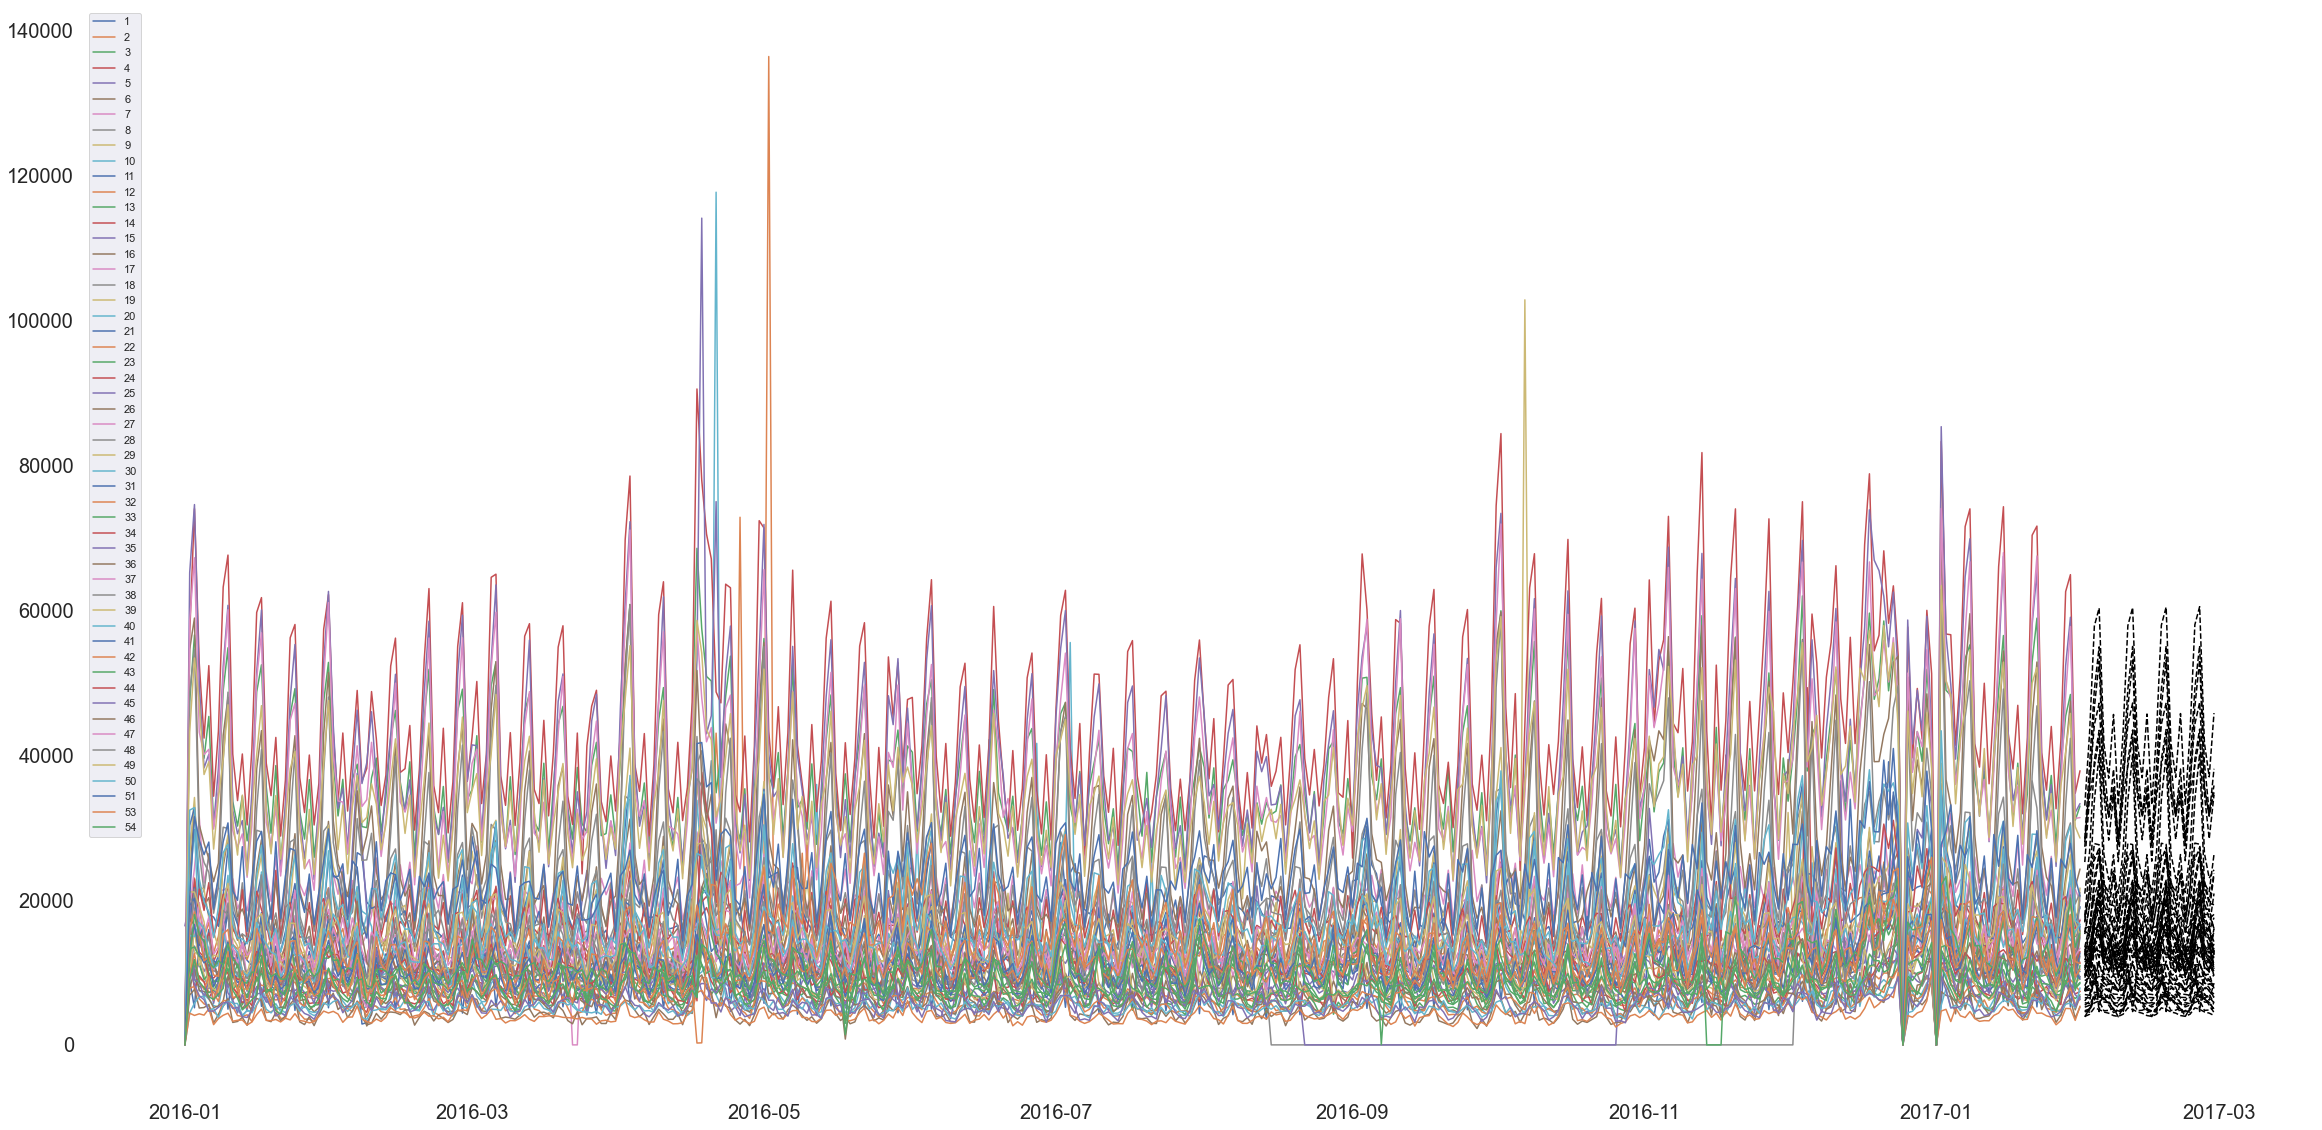

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize = (40,20))
plt.gca().set_facecolor('white')
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
#plt.title("Store Level Predictions - 28 Days",fontsize=30, fontweight='bold',ha='center')

plt.plot(store_nbr_sales_per_day2['sales'], label = store_n)
plt.plot(predictions2,ls='--',c='black')

plt.legend(loc='upper left')
plt.show()


# Results Classifier

The final step of this process is to identify the stores that deviate from the average MAPE score. The stores are then classified according to their performance i.e. actual vs. predicted sales. The model output can be shared with business stakeholders to enable a proactive management approach. The results provide an early indication of future performance for each one of the 54 stores. MAPE scores are calculated and each store is classified into 4 quartiles and labeled as Low, Low/Med, High/Med, and High

In [135]:
d = {'Store':store_n,'MAPE':theta_MAPE}

In [136]:
df_mape = pd.DataFrame(d)
df_mape = df_mape.sort_values('MAPE')
df_mape.MAPE = df_mape.MAPE.round(2)

In [137]:
df_mape['MAPE_QUARTILES'] = pd.cut(df_mape['MAPE'], bins=4, 
                                     labels=['low', 'low_med', 'high_med', 'high'])


In [138]:
df_mape['MAPE_QUARTILES'].value_counts()


low_med     40
low         11
high         2
high_med     1
Name: MAPE_QUARTILES, dtype: int64

In [139]:
labels = ['Group 1','Group 2','Group 3','Group 4']
df_mape['MAPE_groups'] = pd.qcut(df_mape['MAPE'], q=4,labels=labels)


In [140]:
#df_mape
print(df_mape['MAPE_QUARTILES'].unique())

['low', 'low_med', 'high_med', 'high']
Categories (4, object): ['low' < 'low_med' < 'high_med' < 'high']


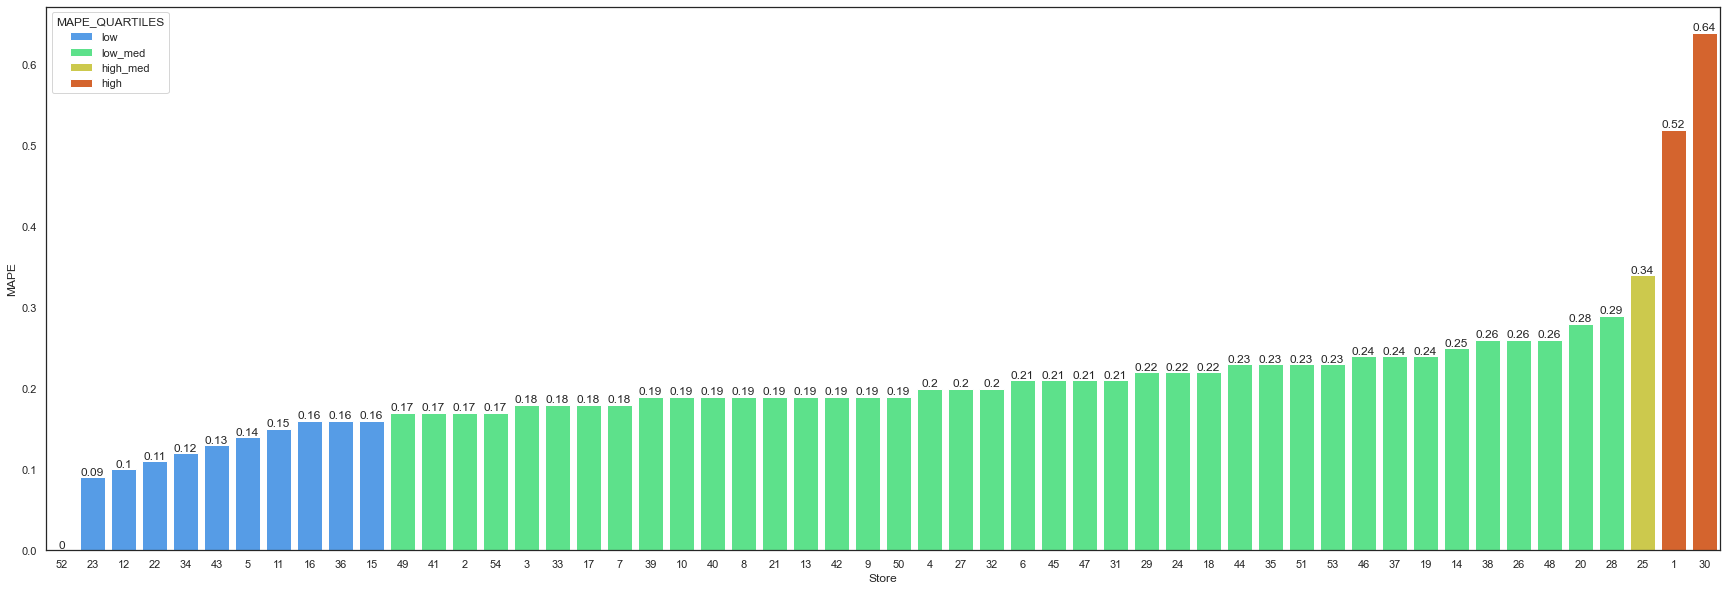

In [141]:
import seaborn as sns


sns.set(rc={'figure.figsize':(30,10)})
sns.set_style("white")
ax = sns.barplot(x='Store', y='MAPE',
                hue='MAPE_QUARTILES', data=df_mape, errwidth=0,
                order=df_mape.sort_values('MAPE').Store,dodge=False,palette='turbo')


for i in ax.containers:
    sns.set(font_scale=1, font='sans-serif',color_codes=False, rc=None)
    ax.bar_label(i,)
    

    

### Final Remarks

The store-level model, utilized in this research, was based on the total sales by store, with the purpose of testing the proposed research. However, in real-life applications thousands of combinations can be expected, because business forecasts can be required at more granular levels and they could include not only total sales but also sales by category and even individual SKU numbers. 

This research has also demonstrated the feasibility of the Theta model Table 2 for forecasting. The results obtained were similar to those from other methods like Holt-Winters and LSTM. However, the Theta model had a better computational performance that can be advantageous, when executing projects with many variables. The overall results of this approach are promising because they successfully identify different levels of predictive performance based on MAPE scores Figure 9 the values are categorized as Low, Low/Med, High/Med, and High. Therefore, the results of this research can provide insights that can inform business decisions related to the optimization of store sales. The performance observed from the Theta model also aligns with other results from the literature that highlights the excellent performance of this method (NIKOLOPOULOS; THOMAKOS, 2020).

It is also important to highlight that the performance of the Theta model in this research is contingent on the dataset tested and the defined time period.

### Project Contribution
The overall objective of this project was to identify when forecasts deviate from the predicted values and enable decision-makers to intervene if necessary. These deviations can be defined as anomalies and their detection is determined by using a forecast model to generate predictions for each store’s future sales. If the observed sales of a given store deviate significantly from the sales forecast, then this could indicate an anomaly.
The literature review indicated the importance of forecast methods for various areas, including but not limited to, business, health policies, and public planning. Forecasting has a long history and some publications applied to the business started to surface in the USA around 1910 (HAWKINS, 2005).

This research also examined several traditional methodologies and common applications of forecasting models, illustrating their significance and relevance. The data source utilized for the project is from Favorita stores located in Ecuador, the data set is available on Kaggle and it provides sales data for 54 stores from 2016 to 2017.

The methods Holt-Winters, Theta Model, and LSTM were applied, independently, to predict sales for one of the stores, the results were compared and based on MAPE scores and computational time.The Theta Model was identified as the best alternative for forecasting sales in the given context.Subsequently, all 54 stores were modeled independently, utilizing the same time periods for both training and test.

The final step of this process was to classify the MAPE scores into 4 categories Low, Low/Med, High/Med, and High to identify which stores are over or underperforming.These classifications could vary depending on specific business objectives. Overall, the project’s contribution is to demonstrate that developing a framework to monitor future outcomes by leveraging forecast methods can provide valuable information to decision-makers on how to optimize sales performance by identifying potential performance variations.


### Limitations and Future Work
There are several limitations to the article that explored three methods for forecasting sales. Firstly, the research only considered a limited number of forecasting methods. While the methods Holt-Winters, Theta Model, and LSTM are commonly used and well-established, there may be other forecast methods that could also be effective and this research likely overlooked other methods that could provide better results.

The LSTM model could also be improved and a more complex architecture could improve results if this project was executed in a cloud environment its computational time would likely not be a factor.
The article only evaluated the performance of these methods on a single data set. While this data set represents the sales of a specific organization, it is possible that the results of the analysis may differ when other data sets are used. As such, the conclusion drawn by this project should not be generalizable to any sales data set. 
Another potential limitation is that the article did not address the issue of hyperparameter optimization. In order to maximize the accuracy and reliability of the forecasts, it may be necessary to fine-tune the hyperparameters of the models. This could involve improving the process for setting up hyperparameters or developing more advanced techniques for optimization.

Overall, these limitations suggest that there are likely further opportunities for improve- ment that could help to address some of these issues and make this approach more attainable to different types of organizations and problems. Some of the areas to be further explored include; testing different data sets to assess if the initial findings can be generalized and replicated to ensure that the outputs can be used with a certain level of confidence.

There are several other methodologies that can be tested to identify models that can provide similar predictions, e.g, ARIMA (du Preez; WITT, 2003) that provides the ability to optimize several hyperparameters and is widely used in both academia and in business applications. There are also packages that offer a convenient process that allows for training and evaluating several models with some level of automation. For example, Prophet [Facebook Prophet library](https://facebook.github.io/prophet/)
 is a forecasting library developed by Facebook which handles some tasks automatically but also permits customization. Another package LazyClassifier [LazyPredict documentation](https://lazypredict.readthedocs.io/en/latest/index.html)
 is a Python library that is built on top of scikit- learn that allows for easy comparison and combination of multiple machine learning models. Unsupervised methods like cluster analysis (XU; WUNSCH, 2005) can be used to group similar stores to assist in the identification based on the model outputs and store attributes, this can assist in the identification of stores that require some sort of intervention. Overall, this research supports the Theta model as a realistic alternative for forecasting business metrics but we should also note the importance of further exploring and validating this approach for other applications.